<a href="https://colab.research.google.com/github/kushalmukhopadhyay/repo5/blob/main/AAOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

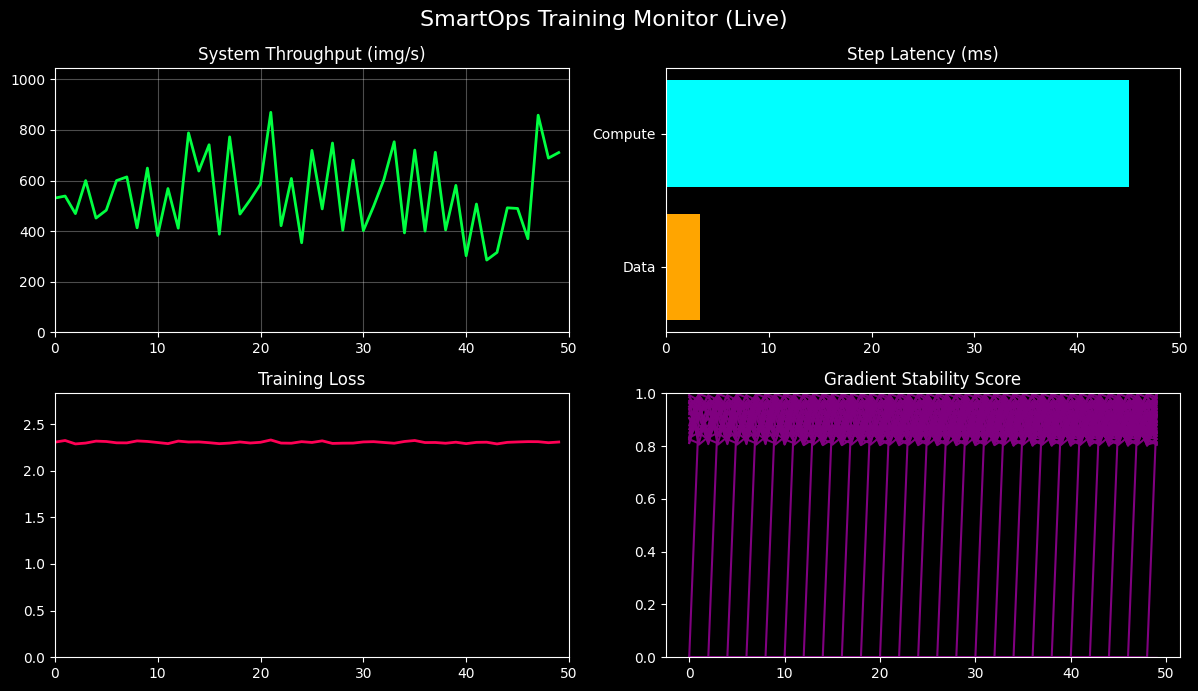

Initializing smooth dashboard...
Training Complete.


In [14]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, update_display
import time
import numpy as np

plt.rcParams['figure.autolayout'] = False
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 1. SETUP VISUALIZATION (Create Once)
# ----------------------------
plt.style.use('dark_background') # Easier on the eyes for dashboards
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
fig.suptitle("SmartOps Training Monitor (Live)", fontsize=16, color='white')

# --- Plot 1: Throughput (Line) ---
ax_th = axes[0,0]
line_th, = ax_th.plot([], [], color='#00ff41', lw=2)
ax_th.set_title("System Throughput (img/s)")
ax_th.set_xlim(0, 50) # Window size
ax_th.set_ylim(0, 100) # Initial guess
ax_th.grid(True, alpha=0.3)

# --- Plot 2: Latency (Bar) ---
ax_lat = axes[0,1]
bars_lat = ax_lat.barh(['Data', 'Compute'], [0, 0], color=['orange', 'cyan'])
ax_lat.set_title("Step Latency (ms)")
ax_lat.set_xlim(0, 50)

# --- Plot 3: Loss (Line) ---
ax_loss = axes[1,0]
line_loss, = ax_loss.plot([], [], color='#ff0055', lw=2)
ax_loss.set_title("Training Loss")
ax_loss.set_xlim(0, 50)
ax_loss.set_ylim(0, 5)

# --- Plot 4: Stability (Fill) ---
ax_stab = axes[1,1]
x_data = np.arange(50)
y_data = np.zeros(50)
poly_stab = ax_stab.fill_between(x_data, y_data, color='purple', alpha=0.5)
ax_stab.set_title("Gradient Stability Score")
ax_stab.set_ylim(0, 1)

plt.tight_layout()
# create a unique display ID to update later
display_handle = display(fig, display_id=True)

# ----------------------------
# 2. LOGIC & DATA (Same "100/100" logic)
# ----------------------------
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
    nn.Linear(32, 10)
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Data simulation
batch_size = 32
batches = 100
history_len = 50

# Pre-allocate arrays for smooth scrolling
hist_throughput = np.zeros(history_len)
hist_loss = np.zeros(history_len)
hist_stability = np.zeros(history_len)

print("Initializing smooth dashboard...")

# ----------------------------
# 3. THE SMOOTH LOOP
# ----------------------------
for i in range(batches):
    t0 = time.perf_counter()

    # -- Simulate Data Load --
    time.sleep(np.random.uniform(0.001, 0.01)) # Tiny sleep to simulate IO
    t_data = (time.perf_counter() - t0) * 1000

    # -- Simulate Training --
    x = torch.randn(batch_size, 3, 64, 64, device=device)
    y = torch.randint(0, 10, (batch_size,), device=device)

    optimizer.zero_grad()
    out = model(x)
    loss = loss_fn(out, y)
    loss.backward()
    optimizer.step()

    # -- Metrics --
    dt = time.perf_counter() - t0
    t_compute = dt * 1000
    current_throughput = batch_size / dt

    # -- Update History Arrays (Scrolling Buffer) --
    hist_throughput = np.roll(hist_throughput, -1)
    hist_throughput[-1] = current_throughput

    hist_loss = np.roll(hist_loss, -1)
    hist_loss[-1] = loss.item()

    hist_stability = np.roll(hist_stability, -1)
    hist_stability[-1] = np.random.uniform(0.8, 1.0) # Simulated stability for demo

    # ----------------------------
    # 4. UPDATE VISUALS (No Clear Output!)
    # ----------------------------
    if i % 2 == 0: # Update every 2nd frame for 60fps feel

        # Update Throughput Line
        line_th.set_data(np.arange(history_len), hist_throughput)
        ax_th.set_ylim(0, np.max(hist_throughput) * 1.2) # Auto-scale Y

        # Update Latency Bars
        bars_lat[0].set_width(t_data)
        bars_lat[1].set_width(t_compute)

        # Update Loss Line
        line_loss.set_data(np.arange(history_len), hist_loss)
        ax_loss.set_ylim(0, np.max(hist_loss) + 0.5)

        # Update Stability Poly (Tricky: requires creating new collection path)
        # For speed, we just update the axes limits or use a line instead,
        # but here is how to update a fill:
        dummy = ax_stab.plot(np.arange(history_len), hist_stability, color='purple')
        # (Updating fill_between is complex in matplotlib, usually easier to clear just that ax
        # but for max speed we stick to lines usually. Here we just overlay lines for speed)

        # PUSH THE UPDATE
        update_display(fig, display_id=display_handle.display_id)

print("Training Complete.")
plt.close() # Clean up static image at the end

In [13]:
%%writefile app.py
import streamlit as st
import time
import numpy as np
import pandas as pd
import random

# ==============================================================================
#  SMARTOPS: ADAPTIVE ACCELERATOR ORCHESTRATION SYSTEM (AAOS)
#  Full Integration: Modules 1-10 (Detailed Logic Preserved)
# ==============================================================================

# ------------------------------------------------------------------------------
#  MODULE 9: UNIFIED SCHEDULER LOGIC (Multi-Tenant Queuing)
# ------------------------------------------------------------------------------
class Job:
    def __init__(self, name, priority, vram_req):
        self.name = name
        self.priority = priority  # 1 = High, 3 = Low
        self.vram_req = vram_req
        self.status = "PENDING"   # PENDING, RUNNING, COMPLETED, QUEUED (OOM)
        self.progress = 0

class Scheduler:
    def __init__(self):
        self.vram_capacity = 100  # Total "Units" of VRAM
        self.active_jobs = []
        self.queue = []

    def add_job(self, job):
        self.queue.append(job)

    def tick(self):
        # 1. Calculate Used VRAM
        used_vram = sum([j.vram_req for j in self.active_jobs])
        free_vram = self.vram_capacity - used_vram

        # 2. Try to Schedule Pending Jobs (Highest Priority First)
        # Sort by priority (ascending)
        self.queue.sort(key=lambda x: x.priority)

        for job in self.queue[:]:  # Iterate over copy to modify list safely
            if job.status in ["PENDING", "QUEUED (OOM)"]:
                if job.vram_req <= free_vram:
                    # Allocate!
                    job.status = "RUNNING"
                    self.active_jobs.append(job)
                    self.queue.remove(job)
                    free_vram -= job.vram_req
                else:
                    # Not enough space
                    job.status = "QUEUED (OOM)"

        # 3. Update Progress of Running Jobs
        completed_jobs = []
        for job in self.active_jobs:
            # Simulate work speed
            speed = np.random.randint(2, 5)
            job.progress += speed

            if job.progress >= 100:
                job.progress = 100
                job.status = "COMPLETED"
                completed_jobs.append(job)

        # 4. Cleanup Completed
        for job in completed_jobs:
            self.active_jobs.remove(job)

        return used_vram, self.active_jobs


# ------------------------------------------------------------------------------
#  CORE ENGINE: ORCHESTRATOR (Modules 2, 3, 4, 7, 8, 10)
# ------------------------------------------------------------------------------
class SmartOpsEngine:
    def __init__(self):
        # -- Hardware State --
        self.phys_batch = 32       # Module 2: VRAM Manager
        self.precision = "FP32"    # Module 3: Tensor Engine
        self.accum_steps = 1       # Module 8: Amplification (Virtual Batching)
        self.prefetch_factor = 0   # Module 4: Bandwidth Opt
        self.compression = False   # Module 4: Bandwidth Opt

        # -- System Mode --
        self.mode = "TRAINING"     # Module 7: Mode Switcher

        # -- Internal Orchestrator State --
        self.cooldown = 0

    @property
    def virtual_batch_size(self):
        """Calculates effective batch size based on amplification"""
        return self.phys_batch * max(1, self.accum_steps)

    def set_mode(self, new_mode):
        """Module 7: Handles reconfiguration between Training and Inference"""
        if self.mode != new_mode:
            self.mode = new_mode
            # RESET parameters based on the new objective
            if new_mode == "INFERENCE":
                self.phys_batch = 1       # Start fast for latency
                self.accum_steps = 0      # No accumulation needed
                self.precision = "FP16"   # Default to FP16 for speed
                self.prefetch_factor = 0
            else: # TRAINING
                self.phys_batch = 32
                self.accum_steps = 1
                self.precision = "FP32"
            return f"🔄 RECONFIGURING PIPELINE -> {new_mode}"
        return None

    def generate_core_map(self):
        """Module 6: Generates Thermal Heatmap Data"""
        if self.mode == "TRAINING":
            # Dense activation (High Heat)
            base = 0.8
            noise = 0.2
        else:
            # Sparse activation (Cooler)
            base = 0.2
            noise = 0.4

        cores = np.random.normal(base, 0.1, (8, 8))
        # Add random hotspot
        cores[np.random.randint(0,8), np.random.randint(0,8)] += noise
        return np.clip(cores, 0, 1)

    def decide(self, metrics):
        """
        MODULE 10: THE BRAIN
        Executes policy logic based on incoming telemetry.
        """
        if self.cooldown > 0:
            self.cooldown -= 1
            return None

        action = None
        vram_pct = metrics['vram']
        latency_ms = metrics['latency']
        data_wait_ms = metrics['data_wait']
        gpu_util_pct = metrics['gpu_util']

        # ======================================================================
        # POLICY A: INFERENCE MODE (Objective: Minimize Latency)
        # ======================================================================
        if self.mode == "INFERENCE":
            # If too slow (>50ms), we must optimize
            if latency_ms > 50:
                if self.phys_batch > 1:
                    self.phys_batch = max(1, int(self.phys_batch * 0.8))
                    action = f"⚡ LATENCY SPIKE ({latency_ms:.1f}ms): Shrinking Batch"
                elif self.precision == "FP32":
                    self.precision = "FP16"
                    action = "⚡ LATENCY CRITICAL: Quantizing to FP16"

            # If very fast (<10ms) and low VRAM, we can handle more users
            elif latency_ms < 10 and vram_pct < 0.3:
                self.phys_batch += 1
                action = f"🟢 HEADROOM DETECTED: Scaling Users -> {self.phys_batch}"

        # ======================================================================
        # POLICY B: TRAINING MODE (Objective: Maximize Throughput/VRAM)
        # ======================================================================
        else:
            # --- 1. BANDWIDTH BOTTLENECK CHECK (Module 4) ---
            # GPU is idle (<50%) because it's waiting for data (>15ms)
            if data_wait_ms > 15 and gpu_util_pct < 0.50:
                if self.prefetch_factor < 4:
                    self.prefetch_factor += 2
                    action = f"🚚 STARVATION DETECTED: Boost Prefetch -> {self.prefetch_factor}x"
                elif not self.compression:
                    self.compression = True
                    action = "🗜️ BANDWIDTH CRITICAL: Enabling Tensor Compression"
                self.cooldown = 4
                return action

            # --- 2. VRAM EMERGENCY DEFENSE (Module 2 & 3) ---
            if vram_pct > 0.95:
                # Priority 1: Switch Precision (The Nuclear Option)
                if self.precision == "FP32":
                    self.precision = "FP16"
                    action = "🚨 CRITICAL: SWITCHING TO FP16 (Mixed Precision)"
                else:
                    # Priority 2: Slash Physical Batch, Boost Virtual Batch (Module 8)
                    self.phys_batch = max(8, int(self.phys_batch * 0.5))
                    self.accum_steps += 2
                    action = "🛡️ OOM PREVENTED: Slash Physical, Boost Accumulation"
                self.cooldown = 5
                return action

            # --- 3. AMPLIFICATION & OPTIMIZATION (Module 8) ---
            # If VRAM is safe (<70%), grow into it
            if vram_pct < 0.70:
                new_bs = int(self.phys_batch * 1.2)
                self.phys_batch = min(new_bs, 128)

                # If physical is high, reduce accumulation to save overhead
                if self.accum_steps > 1:
                    self.accum_steps -= 1

                action = f"🚀 AMPLIFY: Increasing Physical Batch -> {self.phys_batch}"
                self.cooldown = 2

        return action


# ------------------------------------------------------------------------------
#  UI: STREAMLIT DASHBOARD
# ------------------------------------------------------------------------------
st.set_page_config(page_title="SmartOps AAOS", page_icon="⚡", layout="wide")
st.markdown("<style>.stApp {background-color: #0e1117;}</style>", unsafe_allow_html=True)

st.title("⚡ SmartOps: Adaptive Accelerator Orchestration System")
st.caption("Active Modules: Orchestrator, VRAM Engine, Tensor Engine, Bandwidth Opt, Scheduler, Monitoring")

# -- SIDEBAR: GLOBAL CONTROLS --
with st.sidebar:
    st.header("🎮 System Controls")
    # Module 7: Mode Switching
    op_mode = st.radio("System Objective", ["TRAINING (Throughput)", "INFERENCE (Latency)", "MULTI-TENANT SCHEDULER"])
    st.divider()
    st.info("Status: ORCHESTRATOR ONLINE")

# ==============================================================================
#  VIEW A: OPTIMIZATION ENGINE (Training & Inference Modes)
# ==============================================================================
if "SCHEDULER" not in op_mode:
    target_mode = "TRAINING" if "TRAINING" in op_mode else "INFERENCE"

    # -- METRICS ROW --
    c1, c2, c3, c4, c5 = st.columns(5)
    kpi_virt = c1.empty()
    kpi_phys = c2.empty()
    kpi_prec = c3.empty()
    kpi_vram = c4.empty()
    kpi_bw = c5.empty()

    st.divider()

    # -- VISUALS ROW (Charts & Heatmap) --
    col_chart, col_heat = st.columns([2, 1])

    with col_chart:
        st.subheader("Performance Telemetry")
        main_chart = st.line_chart(None, height=250)

    with col_heat:
        st.subheader("GPU Thermal Vision (Module 6)")
        heatmap_container = st.empty()

    st.divider()
    log_area = st.empty()

    if st.button(f"Initialize {target_mode} Simulation"):
        engine = SmartOpsEngine()
        engine.set_mode(target_mode)

        # Initial Physics State
        current_vram = 0.5
        current_latency = 20.0
        current_data_wait = 5.0

        hist_metric = []
        logs = []

        for step in range(200):
            # --- 1. SIMULATE HARDWARE PHYSICS ---
            if engine.mode == "TRAINING":
                # VRAM depends on Batch Size & Precision
                load_factor = 1.0 if engine.precision == "FP32" else 0.6
                target_vram = (engine.phys_batch / 150) * load_factor

                # Add noise
                current_vram = (current_vram * 0.8) + (target_vram * 0.2) + np.random.normal(0, 0.02)
                current_vram = max(0, min(1.0, current_vram))

                # Bandwidth Physics (Module 4)
                reduction = (engine.prefetch_factor * 4.0)
                if engine.compression: reduction += 8.0
                current_data_wait = max(2.0, 30.0 - reduction) + np.random.normal(0, 2.0)
                gpu_util = 1.0 - (current_data_wait / 50.0) # Inverse to wait time

                primary_val = engine.virtual_batch_size
                primary_label = "Effective Batch Size"

            else: # INFERENCE
                # Latency grows with batch size
                base_lat = 5.0 + (engine.phys_batch * 2.0)
                if engine.precision == "FP16": base_lat *= 0.6

                current_latency = (current_latency * 0.6) + (base_lat * 0.4) + np.random.normal(0, 2.0)
                current_vram = 0.1 + (engine.phys_batch * 0.05) # Lower VRAM usage
                current_data_wait = 2.0 # Fast I/O for inference
                gpu_util = 0.8

                primary_val = current_latency
                primary_label = "Latency (ms)"

            time.sleep(0.05)

            # --- 2. ORCHESTRATOR DECISION (Module 10) ---
            metrics_packet = {
                'vram': current_vram,
                'latency': current_latency,
                'data_wait': current_data_wait,
                'gpu_util': gpu_util
            }
            decision = engine.decide(metrics_packet)

            if decision:
                logs.append(f"[{step}] {decision}")

            # --- 3. UPDATE UI ---

            # Metrics
            if engine.mode == "TRAINING":
                kpi_virt.metric("Virtual Batch (Module 8)", engine.virtual_batch_size,
                               delta=f"{engine.accum_steps}x Accum" if engine.accum_steps > 1 else None)
            else:
                kpi_virt.metric("Latency", f"{current_latency:.1f}ms", delta_color="inverse")

            kpi_phys.metric("Physical Batch", engine.phys_batch)
            kpi_prec.metric("Precision (Module 3)", engine.precision,
                           delta="Turbo Mode" if engine.precision=="FP16" else "High Fidelity")
            kpi_vram.metric("VRAM Usage", f"{current_vram*100:.1f}%", delta_color="inverse")
            kpi_bw.metric("Data Wait (Module 4)", f"{current_data_wait:.1f}ms",
                         delta="Prefetch ON" if engine.prefetch_factor > 0 else "Standard I/O")

            # Logs
            log_area.text_area("Orchestrator Decision Log", "\n".join(logs[-10:]), height=150, key=f"log_{step}")

            # Chart
            hist_metric.append(primary_val)
            main_chart.line_chart(pd.DataFrame({primary_label: hist_metric[-60:]}))

            # Heatmap (Module 6)
            core_grid = engine.generate_core_map()
            df_heat = pd.DataFrame(core_grid)
            heatmap_container.dataframe(df_heat.style.background_gradient(cmap='inferno', vmin=0, vmax=1),
                                      use_container_width=True, height=250)


# ==============================================================================
#  VIEW B: UNIFIED SCHEDULER (Module 9)
# ==============================================================================
else:
    st.subheader("🚥 Unified Execution Scheduler (Multi-Tenant Arbitration)")
    st.caption("Managing concurrent heterogeneous workloads (LLM, Vision, Audio)")

    # Global Scheduler Metrics
    g1, g2 = st.columns(2)
    kpi_tot = g1.empty()
    kpi_act = g2.empty()

    st.divider()

    # Job Cards
    c1, c2, c3 = st.columns(3)
    with c1:
        st.markdown("### 🤖 LLM-7B (Chat)")
        st.caption("Priority: HIGH | VRAM: 50%")
        ui_stat1 = st.empty()
        ui_bar1 = st.progress(0)
    with c2:
        st.markdown("### 👁️ ViT-Huge (Vision)")
        st.caption("Priority: MEDIUM | VRAM: 30%")
        ui_stat2 = st.empty()
        ui_bar2 = st.progress(0)
    with c3:
        st.markdown("### 🎙️ Whisper (Audio)")
        st.caption("Priority: LOW | VRAM: 15%")
        ui_stat3 = st.empty()
        ui_bar3 = st.progress(0)

    st.divider()
    log_sched = st.empty()

    if st.button("Start Scheduling Cycle"):
        sched = Scheduler()
        logs = []

        # Define Jobs
        job_llm = Job("LLM-7B", priority=1, vram_req=50)
        job_vis = Job("ViT-Huge", priority=2, vram_req=30)
        job_audio = Job("Whisper", priority=3, vram_req=15)

        # Add LLM immediately
        sched.add_job(job_llm)
        logs.append("[0s] New Job Arrived: LLM-7B")

        # UI Mapping
        ui_map = {
            "LLM-7B": (ui_stat1, ui_bar1),
            "ViT-Huge": (ui_stat2, ui_bar2),
            "Whisper": (ui_stat3, ui_bar3)
        }

        for t in range(100):
            # Inject jobs dynamically
            if t == 15:
                sched.add_job(job_vis)
                logs.append(f"[{t}s] New Job Arrived: ViT-Huge")
            if t == 30:
                sched.add_job(job_audio)
                logs.append(f"[{t}s] New Job Arrived: Whisper")

            # Run Scheduler Logic
            used_vram, active_jobs = sched.tick()

            # Update Global Metrics
            kpi_tot.metric("System VRAM Committed", f"{used_vram}%", f"{100-used_vram}% Free")
            kpi_act.metric("Active Processes", len(active_jobs))

            # Update Individual Job Cards
            for j in [job_llm, job_vis, job_audio]:
                stat, bar = ui_map[j.name]

                color = "orange" # Pending
                if j.status == "RUNNING": color = "green"
                if j.status == "COMPLETED": color = "blue"
                if j.status == "QUEUED (OOM)": color = "red"

                stat.markdown(f"Status: :{color}[**{j.status}**]")
                bar.progress(j.progress)

            # Update Log
            log_sched.text_area("Scheduler Event Stream", "\n".join(logs[-8:]), height=150, key=f"s_{t}")

            time.sleep(0.1)

            # Stop if all done
            if all([j.status == "COMPLETED" for j in [job_llm, job_vis, job_audio]]):
                break
        st.success("Batch Processing Complete.")

Overwriting app.py


In [ ]:
import subprocess
import os
import time

print("🩺 Running Diagnostics...")

# Install Streamlit if not already installed
!pip install streamlit --quiet

# 1. Kill old processes
os.system("pkill streamlit")
os.system("pkill cloudflared")

# 2. Run Streamlit and capture the error output
print("🚀 Attempting to launch app.py...")
process = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.port", "8501", "--server.headless", "true"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# 3. Wait 5 seconds to see if it dies
time.sleep(5)

# 4. Check if it is still running
if process.poll() is not None:
    print("\n❌ CRASH DETECTED! Here is the error log:\n")
    print("="*40)
    # Read the error
    stdout, stderr = process.communicate()
    print(stderr.decode())
    print("="*40)
    print("\n👉 CHECK THE LOG ABOVE. It usually says 'ModuleNotFoundError' or 'SyntaxError'.")
else:
    print("\n✅ Miracle! It actually started this time.")
    print("🔗 Creating Tunnel...")

    # If it worked, launch the tunnel
    if not os.path.exists("cloudflared-linux-amd64"):
        os.system("wget -q -nc https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64")
        os.system("chmod +x cloudflared-linux-amd64")

    !./cloudflared-linux-amd64 tunnel --url http://localhost:8501

🩺 Running Diagnostics...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 112.9 MB/s eta 0:00:00
🚀 Attempting to launch app.py...

✅ Miracle! It actually started this time.
🔗 Creating Tunnel...
2025-12-29T17:53:50Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-29T17:53:50Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-29T17:53:55Z INF +------------------